# Homework 5 - Exploring StackOverflow!

![Alt Text](https://www.linuxadictos.com/wp-content/uploads/stack-overflow-1024x244.jpg.webp)

## 1. Data

The first step, as always, is to download the data you will be working on. You can download the data to build the system [here](https://snap.stanford.edu/data/sx-stackoverflow.html). Please download the **3 files** which can be found under the description ['Answers to questions', 'Comments to questions', 'Comments to answers']
  
  In particular, each file will contain the following information:
  * __Answers to questions__ - User u answered user v's question at time t
  * __Comments to questions__ - User u commented on user v's question at time t
  * __Comments to answers__  - User u commented on user v's answer at time t

Unless specified differently we will handle the 3 graphs together, therefore as a first step please think about a nice and appropriate manner to merge them. You are free to merge them as you prefer, but we do expect the output graph to be a weighted gragh. For instance, imagine you have a user X has answered to a question and comment from user Y. In the combined graph we expect you to have a weighted link between these two users. How you construct this weight is fully up to you :). If the algorithm we request you does not have a weighted variant please mention it clearly and convert the weighted graph into an unweighted one.

Some recommendations that might be helpful for dealing with the data is:

 - The date is provided with a very high precision, please round it to a reasonable value (e.g. day, hours, etc. whatever you feel makes more sense)
 - You might also see that there are several answers/comments which the user answer do to themselves... please deal with these accordingly and explain what you have decided to do. 
 - We are aware that the data is a lot. For this reason we typically ask you to only focus on a smaller intrerval of time. Please test all your implementations on a sufficiently large interval of time, and use this in your benefit to get the best possible results. 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Solution 1

### Preprocessing of the txt files

#### Timestamps
The data are to be cleaned, starting from the timestamps I've made two operations:

1) The dataset are really huge and the timestamp are too precise, so I've decided to consider only time **windows of at least one day**.
    in order to to this I've built a function (```cast_times```) that for each line of the txt files takes the timestamp and replace it with the same timestamp subtracting the reminder of the division for 86400 (number of seconds in a day)
2) The timestamps refers to the 01 Jan 1970, a little bit out of date... So I've decided to add to every timestamp the number 1221436800 that's the timestamp of the day   when (accordingly with [wikipedia en](https://en.wikipedia.org/wiki/Stack_Overflow)) the first public beta release of stackoverflow has been created.

#### Format
It's decisely more easy to work with csv files, so I've saved the results into csv files

In [1]:
import functions
import networkx as nx
import math
import statistics
import collections
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt 

In [56]:
import heapq

class PriorityQueue():
    '''
        A class that wraps the implementation of the heap with a priority queque.
        Each inserted node has to be in the form (cost, index, node) where index 
        will be used by heapq in the case that the comparison among cost fails
    '''

    def __init__(self, nodes):
        self.data = nodes
        heapq.heapify(self.data)

    def get(self):
        return heapq.heappop(self.data)

    def push(self, node):
        heapq.heappush(self.data, node)
        
    def empty(self):
        return len(self.data)

def my_dijkstra(G, i, j):
    '''
        The implementation of Dijkstra algorithm it returns a list of tuple made by:
        (the node, their father and their cost) in order of visit

    '''
    visited = set()
    idx=0
    frounteer = PriorityQueue([(0,idx,(i,i, 0))])
    path = []
    while frounteer.empty():
        f = frounteer.get()[2]
        node, father, cost = f
        idx += 1
        if node in visited: continue
        # If the node is already in the frounteer with a greater cost it will be drown after this (it'll be already visited)
        path.append((node, father, cost))
        if node == j:
            return path
    
        visited.add(node)
        if node not in G:
            continue
        for son, weight in G[node]:
            if not son in visited:
                frounteer.push((cost+weight,cost+weight,(son, node, cost+weight)))
    return path

In [2]:
print("Starting preprocessing for: answer to questions")
functions.cast_times('data/original/a2q.txt')
print("Done\n")

print("Starting preprocessing for: comment to answers")
functions.cast_times('data/original/c2a.txt')
print("Done\n")

print("Starting preprocessing for: comment to questions")
functions.cast_times('data/original/c2q.txt')
print("Done\n")

Starting preprocessing for: answer to questions
the output file: data/original/a2q_casted.csv already exists!
Done

Starting preprocessing for: comment to answers
the output file: data/original/c2a_casted.csv already exists!
Done

Starting preprocessing for: comment to questions
the output file: data/original/c2q_casted.csv already exists!
Done



### Exploring the data

In the following cells I've analysed the date range over which the relationships are distributed and if there's some user that is connected in some way to itself

In [3]:
import pandas as pd

# Reading the processed csv files
a2q = pd.read_csv('data/original/a2q_casted.csv', header='infer')
c2a = pd.read_csv('data/original/c2a_casted.csv', header='infer')
c2q = pd.read_csv('data/original/c2q_casted.csv', header='infer')

In [4]:
from datetime import datetime
print("a2q:")
print(f"\tmin_timestamp: {a2q.time.min()} in_date: {datetime.fromtimestamp(a2q.time.min())}")
print(f"\tmax_timestamp: {a2q.time.max()} in_date: {datetime.fromtimestamp(a2q.time.max())}")
print("c2a:")
print(f"\tmin_timestamp: {c2a.time.min()} in_date: {datetime.fromtimestamp(c2a.time.min())}")
print(f"\tmax_timestamp: {c2a.time.max()} in_date: {datetime.fromtimestamp(c2a.time.max())}")
print("c2q:")
print(f"\tmin_timestamp: {c2q.time.min()} in_date: {datetime.fromtimestamp(c2q.time.min())}")
print(f"\tmax_timestamp: {c2q.time.max()} in_date: {datetime.fromtimestamp(c2q.time.max())}")

a2q:
	min_timestamp: 1221436800 in_date: 2008-09-15 02:00:00
	max_timestamp: 1227398400 in_date: 2008-11-23 01:00:00
c2a:
	min_timestamp: 1221436800 in_date: 2008-09-15 02:00:00
	max_timestamp: 1227398400 in_date: 2008-11-23 01:00:00
c2q:
	min_timestamp: 1221436800 in_date: 2008-09-15 02:00:00
	max_timestamp: 1227398400 in_date: 2008-11-23 01:00:00


In [5]:
a2q[a2q.user_from.isin(a2q.user_to)]

,user_from,time,user_to


In [6]:
c2a[c2a.user_from.isin(c2a.user_to)]

,user_from,time,user_to


In [7]:
c2q[c2q.user_from.isin(c2q.user_to)]

,user_from,time,user_to


## Getting the graphs
Now we've the dataframes containing:<br>
```	user_from	time	user_to```<br>
that are respectively the user id that has the interaction (comment or answer), the timestamp starting from the 15 Sep 2008 where this happened and the userid that has received it on it's action (answer or question).

### Processing the dataframes

1) When it's asked to build a graph for specific timestamps intuitivelly it's more convenient to **filter only the rows** where the time attribute is in the given range, so it'll be the first step.

2) Once we have only the row of interest we need to estabilish how to connect the users, well it can be done using a weighted edge where the weight it's the number of interaction that two users had in the specific interval of time, so we'll pass from a dataframe with two user and one timestamp for each row to a dataframe with the two users of above and a counter that **counts the occurrencies for each pair**. This counter will be also the weight in the final graph.

3) Once we've this data we've all, so the next step is to build a graph starting from it, we've done it **representing the graph as a dictionary** containing the adiacence list of each node that has exiting edges, and this structure is **wrapped into a more general class** called ```MyGraph``` that is built by a dataframe in the form (user, user, weight) and will the methods to implement functions for the part 2.

## Examples
In the following cells I'll show how most of these methods works

In [8]:
filtered = functions.filter_dataframe_dates(c2q, date_range=('2008-11-13', '2008-11-23'))
filtered

,user_from,time,user_to
19205128,17389,1226534400,1444433689
19205129,5105044,1226534400,1443530974
19205130,929510,1226534400,1438280294
19205131,5179979,1226534400,1452019156
19205132,885189,1226534400,1438259025
...,...,...,...
20231193,141172,1227312000,1456018680
20231194,871050,1227312000,1454636399
20231195,5884566,1227312000,1454637029
20231196,4389062,1227312000,1454647251


In [9]:
print(f"\tmin_timestamp: {filtered.time.min()} in_date: {datetime.fromtimestamp(filtered.time.min())}")
print(f"\tmax_timestamp: {filtered.time.max()} in_date: {datetime.fromtimestamp(filtered.time.max())}")

	min_timestamp: 1226534400 in_date: 2008-11-13 01:00:00
	max_timestamp: 1227312000 in_date: 2008-11-22 01:00:00


In [10]:
weighted = functions.time_to_weight(filtered)
weighted.sort_values(by='time', ascending=False)

,user_from,user_to,time
779730,5336818,1455852631,2
24483,62576,1454325288,2
789760,5355912,1442822575,2
684049,5165935,1452565553,1
684037,5165930,1438359378,1
...,...,...,...
342028,2026276,1440638002,1
342029,2026276,1440778413,1
342030,2026276,1440785486,1
342031,2026276,1441741834,1


In [11]:
graph = functions.MyGraph(weighted)
print(f"Created a graph with {len(graph.nodes)} nodes")

Created a graph with 1160597 nodes


## Putting all together

We can now employee two functions of the [functions.py](functions.py) file that are usefull to create directly the graphs starting from the relative path of the csv file and the date_range over which filter the data:
1) ```get_single_graph``` that returns a graph that refers to a single csv file
2) ```get_global_graph``` that returns the graph that is the union f the three files. At this point is important to undestrand how to merge the edges and this is done by using three coefficients (one for type of edge) that multiplies the weight of the relative edges in the datasets. In this way we can merge the three graphs maybe saying that an answer to a question is a more important interaction than a comment to an answer that's an interaction more important to a comment to a question, so we can evaluate the first 3, the second 2 and the third 1.

### WARNING!!!
Using big time range will **drastically slow down** the execution

In [12]:
G = functions.get_global_graph(['data/original/a2q_casted.csv','data/original/c2a_casted.csv', 'data/original/c2q_casted.csv'], date_range=('2008-11-13', '2008-11-23'), coefficients=[3,2,1])

reading the files:
	-answer to questions: data/original/a2q_casted.csv	-comment to answers: data/original/c2a_casted.csv	-comment to questions: data/original/c2q_casted.csv
done in 12.7s
filtering the dataframes...
done in 0.975s
generating the weights
- multiplying by the coefficients: [3, 2, 1]
done in 0.78s
putting all togheter, it may require some time...
done in 1.491s
retrieving the graph
done in 12.699s tot time elapsed: 28.648


In [13]:
g_partial = functions.get_single_graph('data/original/a2q_casted.csv', date_range=('2008-11-13', '2008-11-14'))

Reading the file: data/original/a2q_casted.csv
done in 3.464s
Retrieving the graph...
done in 1.782s


## Functionalities

### Functionality 1 - Get the overall features of the graph
It takes in input:

One of the 3 graphs
The output should return:

Whether the graph is directed or not

Number of users

Number of answers/comments

Average number of links per user

Density degree of the graph

Whether the graph is sparse or dense



In [43]:
def get_friends(NODE,G):
  adj=G.__dict__["adiacency_lists"]
  amici=[]
  for j in range(len(adj[NODE])):
    amici.append(adj[NODE][j][0])
  return amici
  
def direction(G):
  adj=G.__dict__["adiacency_lists"]
  for i in adj.keys():
    for j in range(len(adj[i])):
      if adj[i][j][0] in adj.keys():
        if i not in get_friends(adj[i][j][0],G):
          return False
      elif adj[i][j][0] not in adj.keys():
        return "Directed"
  return "Undirected"

def shape_of(G):
  adj=G.__dict__["adiacency_lists"]
  N_ans=0
  nodes=set(adj.keys())
  for i in adj.keys():
    for j in range(len(adj[i])):
      nodes.add(adj[i][j][0])
      N_ans+=adj[i][j][1]
  return(len(nodes),N_ans)

def dense(G):
  adj=G.__dict__["adiacency_lists"]
  density=[]
  for i in adj.keys():
    density.append(len(adj[i])) 
  zeri=[0]*(shape_of(G)[1]-(len(density)))
  zeri.extend(density)
  E=sum(density)
  V=shape_of(G)[1]
  return(statistics.mean(density),zeri,(E*2)/(V*(V-1))) 

def Funcionality1(G):
  return direction(G),shape_of(G),dense(G)

### Visualization 1 - Visualize the overall features of the graph
Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input.

In [44]:
def choose_the_graph():

  # let the user choose  which type of graoh he is interested in
  graph_type = input('Choose a graph: \nA: Graph with answers to questions \nB: Graph with comments to questions \nC: Graph with comments to answers\n')
  if graph_type == 'A':
    choose_graph= functions.get_single_graph('data/original/a2q_casted.csv')
  elif graph_type == 'B':
    choose_graph= functions.get_single_graph('data/original/c2q_casted.csv')
  elif graph_type == 'C':
    choose_graph = functions.get_single_graph('data/original/c2a_casted.csv')
  return(choose_graph)

Reading the file: data/original/c2a_casted.csv
done in 5.303s
Retrieving the graph...
done in 155.013s
----------  ---------------------
Undirected  Directed
Users       24957852
Answers     25405374
Avarage     17.536442277293744
Sparse      7.872259055464513e-08
----------  ---------------------


/Users/alessandro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


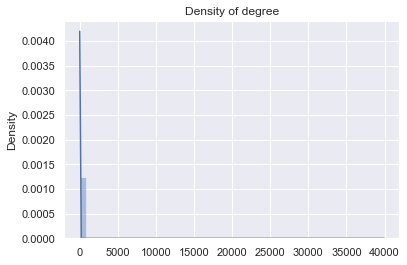

In [45]:
def Visualization1():
  G = choose_the_graph()

  func = Funcionality1(G)

  print(tabulate([['Undirected', func[0]], ['Users', func[1][0]],['Answers', func[1][1]],['Avarage', func[2][0]],['Sparse', func[2][2]]]))
  sns.set(style="darkgrid")
  plt.title("Density of degree")
  sns.distplot(dense(G)[1])
  plt.show()
Visualization1()

### Functionality 2 - Find the best users!
It takes in input:

A user/node
An interval of time
One of the following metrics: Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
The output should return:

The value of the given metric applied over the complete graph for the given interval of time
Give an explanaition regarding the features of the user based on all of the metrics (e.g. if the betweeness metric is high, what does this mean in practice, what if the betweeness is low but it has a high PageRank value, etc.)

In [50]:
#functions 
import math
def get_friends(NODE,G):
  adj=G
  amici=[]
  if NODE in G.keys():
    for j in range(len(adj[NODE])):
      amici.append(adj[NODE][j][0])
  else: 
    amici=[]
  return amici

def Nodes(G):
  N_ans=0
  nodes=set(G.keys())
  for i in G.keys():
    for j in range(len(G[i])):
      nodes.add(G[i][j][0])
      N_ans+=G[i][j][1]
  return(list(nodes))

def income(figlio,G):
  padri=[]
  for padre, figli_pesi in G.items(): 
    for figlio_peso in figli_pesi:
      if  figlio_peso[0]== figlio:
        padri.append(padre)
  return padri

def number_of_shortest_path(a,G):
  Node=Nodes(G)
  N=len(Node)
  distance= [math.inf]*N
  path=[0]*N
  index_source=Node.index(a)
  import heapq
  queque=[]
  distance[index_source]=0
  path[index_source]=1
  heapq.heappush(queque,(0,str(a)))
  while len(queque) !=0:
    length, current =heapq.heappop(queque)
    curr_index=Node.index(int(current))
    if int(current) in G.keys():
      for i in G[int(current)]:
        v_index=Node.index(i[0])
        if distance[v_index]>(distance[curr_index]+i[1]):
          heapq.heappush(queque,(length+i[1],str(i[0])))
          distance[v_index]=distance[curr_index]+i[1]
          path[v_index]=path[curr_index]
        elif distance[v_index]==(distance[curr_index]+i[1]):
          path[v_index]=path[v_index]+path[curr_index]
    else:
      continue
  return path,distance

def number_of_shortest_path_avoiding(a,G,node_to_avoid):
  Node=Nodes(G)
  N=len(Node)
  distance= [math.inf]*N
  path=[0]*N
  index_source=Node.index(a)
  import heapq
  queque=[]
  distance[index_source]=0
  path[index_source]=1
  heapq.heappush(queque,(0,str(a)))
  while len(queque) !=0:
    length, current =heapq.heappop(queque)
    curr_index=Node.index(int(current))
    if int(current) in G.keys():
      for i in G[int(current)]:
        if i[0]==node_to_avoid:
          WL=math.inf
        else:
          WL=i[1]
        v_index=Node.index(i[0])
        if distance[v_index]>(distance[curr_index]+WL):
          heapq.heappush(queque,(length+i[1],str(i[0])))
          distance[v_index]=distance[curr_index]+i[1]
          path[v_index]=path[curr_index]
        elif distance[v_index]==(distance[curr_index]+WL):
          path[v_index]=path[v_index]+path[curr_index]
    else:
      continue
  return path,distance

def my_dijkstra(G, i, j):
    '''
        The implementation of Dijkstra algorithm it returns a list of tuple made by:
        (the node, their father and their cost) in order of visit

    '''
    visited = set()
    idx=0
    frounteer = PriorityQueue([(0,idx,(i,i, 0))])
    path = []
    while frounteer.empty():
        f = frounteer.get()[2]
        node, father, cost = f
        idx += 1
        if node in visited: continue
        # If the node is already in the frounteer with a greater cost it will be drown after this (it'll be already visited)
        path.append((node, father, cost))
        if node == j:
            return path
    
        visited.add(node)
        if node not in G:
            continue
        for son, weight in G[node]:
            if not son in visited:
                frounteer.push((cost+weight,cost+weight,(son, node, cost+weight)))
    return path

def choose_the_metric(G,NODE):
  # let the user choose  which type of metric he is interested in
  metric_type = input('Choose a metric: \nA: Pagerank \nB: Betweeness \nC: ClosenessCentrality\nD: DegreeCentrality \n')
  if metric_type == 'A':
    print("You've choosen the metric page rank")
    metric = PageRank(G,NODE,alpha=0.85,iter=100)
  elif metric_type == 'B':
    print("You've choosen the metric betweennes")
    metric = betweennes(G,NODE)
  elif metric_type == 'C':
   metric = closeness(G,NODE)
   print("You've choosen the metric closeness")
  elif metric_type == 'D':
    print("You've choosen the metric Degree centrality")
    metric = DegreeCentrality(G,NODE)
  return(metric)

#Betweenness
def betweennes(G,NODE):
  nodes=Nodes(G)
  BiBBi=0
  nta_index=nodes.index(NODE)
  for n in nodes:
    if n!=NODE:
      path1,dist1=number_of_shortest_path(n,G)
      path2,dist2=number_of_shortest_path_avoiding(n,G,NODE)
      del path1[nta_index]
      del path2[nta_index]
      del dist1[nta_index]
      del dist2[nta_index]
      for j in range(len(path1)):
        if dist1[j]<dist2[j] and path1[j]!=0:
          BiBBi+=1
        if dist1[j]==dist2[j] and path1[j]!=0:
          BiBBi+=(path1[j]-path2[j])/(path1[j])
    else:
       continue
  return BiBBi

#PageRank
def PageRank(G,NODE,alpha=0.85,iter=100):
  for it in range(iter):
      V=Nodes(G)
      N=len(V)
      id=V.index(NODE)
      PR=dict((i, 1/N) for i in V)
      NU=dict((i,len(get_friends(i,G)) ) for i in V)
      for i in V:
        if len(income(i,G))==0:
          E=[0]
        for j in income(i,G):
          E=[]
          if NU[j]!=0:
            E.append(PR[j]/NU[j])
          else: 
            E.append(0)
        PR[i]=((1-alpha)/N)+alpha*(sum(E))
  return(PR[id])

#ClosenessCentrality 
def closeness(G,NODE):
  V=Nodes(G)
  deno=0
  for i in V:
    if i!=NODE:
      deno+=my_dijkstra(G, NODE, i)[-1][-1]
  if deno==0:
    return 0
  else:
    return (len(V)-1)/deno

#DegreeCentrality
def DegreeCentrality(G,NODE):
  W=0
  for a in G[NODE]:
      W+=int(a[1])
  return W/(len(Nodes(G))-1)

def functionality2(PG ,NODE,time):#G è un path time ('2008-11-13', '2008-11-14')
  G= functions.get_single_graph(PG, date_range=time)
  G=G.__dict__["adiacency_lists"]
  return choose_the_metric(G,NODE)

### Visualitation 2


In [47]:
def create_my_graph(g):
  myG = nx.DiGraph()
  for u in list(g.keys()):
    for v in g[u]:
      if u != v[0]:
        myG.add_edge(u, v[0],weight=v[1])
  return myG
def create_my_subgraph(g, NODE):
  # create a graph
  myG=create_my_graph(g)
  # select the neighbors of an input node
  node_neighbors = [NODE]
  neighbors = g[NODE]
  for node in neighbors:
    node_neighbors.append(node[0])
  # create the subgraph with networkx
  subG = myG.subgraph(node_neighbors)  
  return(subG)
def plot_subgraph(g, NODE,M):
  import matplotlib.pyplot as plt

  # create the sub graph
  subG = create_my_subgraph(g,NODE)

  pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 12)  
  edges = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v]

  # add nodes to the graph
  nx.draw_networkx_nodes(subG, pos, node_size=800, node_color='olive', 
                         alpha = .5, label = 'Neighbors of input node')

  # draw the node of interest (input)
  nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [NODE], 
                         node_color='crimson', label = 'Input node: {}'.format(NODE))
  nx.draw_networkx_edges(subG, pos, edgelist=edges, width=3, alpha = 0.8, edge_color="steelblue", 
                         arrowsize=15, connectionstyle='arc3,rad=0.05')
  ax = plt.gca()
  ax.margins(0.03)
  box = dict(boxstyle='round', facecolor='snow', alpha=0.7, edgecolor="grey")
  plt.suptitle('Value of Metric choosen: {}'.format(M,M),x= .51,y = 0.65, fontsize = 8, bbox=box, horizontalalignment = 'left')
  plt.show()
def visualization2(PG,NODE,time):
    M=functionality2(PG,NODE,time)
    G=functions.get_single_graph(PG, date_range=time)
    G=G.__dict__["adiacency_lists"]
    plot_subgraph(G, NODE,M)

Reading the file: data/original/c2q_casted.csv
done in 4.173s
Retrieving the graph...
done in 1.585s
You've choosen the metric Degree centrality
Reading the file: data/original/c2q_casted.csv
done in 4.118s
Retrieving the graph...
done in 1.555s


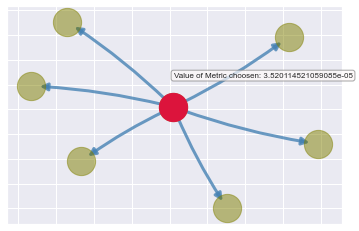

In [51]:
visualization2("data/original/c2q_casted.csv", 893,time=('2008-11-13', '2008-11-14')) # Choose the metric D

### Testing
since the computation is really time expensive, we've shown the application of the algorithm for the other metrics on a sample graph that's not coming from the stackoverflow datasets

In [52]:
sample_g = {0:[(1,1), (5,2)],1:[(2,1),(3,1), (4,3)], 2:[(0,3), (7, 5)], 3:[(4, 1),(5, 1)], 4:[(5,0),(6, 1)], 5: [(7,2)], 6:[(7,0)]}

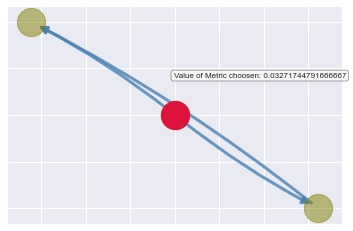

In [53]:
# Page rank example 

pr = PageRank(sample_g,3,alpha=0.85,iter=100)
plot_subgraph(sample_g, 3,pr)

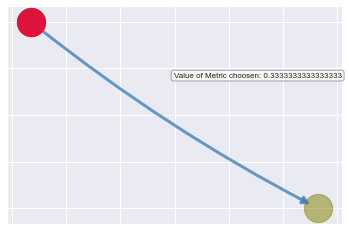

In [54]:
# Betweennes example

bt = betweennes(sample_g, 5)
plot_subgraph(sample_g, 5,bt)

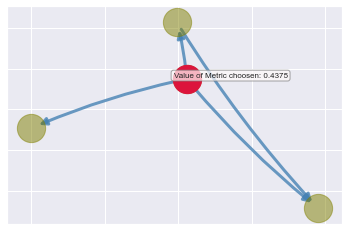

In [57]:
# Closeness example

cl = closeness(sample_g,1)
plot_subgraph(sample_g, 1, cl)

### Functionality 3 - Shortest Ordered Route
It takes in input:
* An interval of time
* A sequence of users p = [p_2, ..., p_n-1]
+ Initial user p_1 and an end user p_n
Implement an algorithm that returns the shortest walk that goes from user p_j to p_n, and that visits in order the nodes in p. The choice of p_j and p_n can be done randomly (or if it improves the performance of the algorithm you can also define it in any other way)

Consider that:

The algorithm needs to handle the case that the graph is not connected, thus not all the nodes in p are reachable from p_1. In such scenario, it is enough to let the program give in output the string "Not possible".
That the graph is weighted
Since we are dealing with walks, you can pass more than once on the same node p_i, but you have to preserve order. E.g.: if you pass through p_2 and you are going to p_3, you can pass through p_10, but once you will be in p_9, you will have to go back to p_10 as well.

### Idea.
This problem consists in find the shortest ordered **route**, not path, so we can have repetition either of edges and of nodes, so we need to pay attention to potential inifinte loops.<br>
The main idea is that finding the shortest route that traverses all of the given nodes in that order is equal to find the route that is the union of the shortest paths that link each successive pair of nodes.

We know really well how to compute this shortest path (Dijkstra) and the algorithm that I've thinked as more suitable for our porpouses is the following:
```
---------––-----------------––-----------------––-------------
Input: G, nodes= [p_1, p_2, ..., p_n]                                
Output: [p_1, .., p_2, ..., p_3, ..., p_n] the shortest route 
---------––-----------------––-----------------––-------------
for i in range(0, len(nodes)-1){
    ret += Dijkstra(G, nodes[i], nodes[i+1])
}

```

Where ```Dijkstra(G, n1, n2)``` returns the cheapest path that links n1 with n2 in the graph G.

All these words are for saying that since it's really hard to test this algorithm over big portion of the graph given its huge dimension and that even if all the runs are good, the real guarantees on the correctness of this algorithm resides on the fact that it's simply subsequent application of Dijkstra and this algorithm has the following charateristics:
1. Always **terminate** because or this route exists, so if we apply subsequently Dijkstra it'll terminate each time or it doesn't exists, so in one application disjkstra fails, so it returns None (of course the list of nodes has to be **finite**)
2. The route is the **shortest** accordingly with the weight, since at each step we find the shortest path for two nodes in the list if exists a path with a lower cost it would means that we can go from one node to another in a cost lower than the estimated, so we have a path from two nodes that Dijskstra didn't find, but it doesn't make sense since Dijkstra is a correct algorithm.
3. The complexity is of the order of the lenght of the list of nodes (n) times the Dikstra complexity


### IMPORTANT!!
The class PriorityQueue and the algorithm 'my_dijkstra' are already defined at the **beginning of the file** since they are being used, for the closeness functionality, so refer to that cell to see the code.

In [26]:
G = {0:[(1,1), (5,2)],1:[(2,1),(3,1), (4,3)], 2:[(0,3), (7, 5)], 3:[(4, 1),(5, 1)], 4:[(5,0),(6, 1)], 5: [(7,2)], 6:[(7,0)]}
dij = my_dijkstra(G, 0, 7)

def get_path(visited):
    '''
        Given the path in the form of the Dijkstra output it read that list and return a tuple made by:
        the list of nodes in the path in the order of visit
        the total cost
    '''
    i = len(visited)-1
    ret = []
    while i>=0:
        node, father, _ = visited[i]
        ret.append(node)

        if node==father:
            break
        for _ in range(1, i+1):
            i-=1
            if visited[i][0]==father:
                break
    return list(reversed(ret)), visited[-1][-1]



print(get_path(dij))

([0, 5, 7], 4)


In [27]:
def concat_path(path_list):
    ''' 
        Concatenates a list of path in the form [[n1, n2, n3],[n3, n4], [n4, n5]]
        into [n1,n2,n3,n4,n5] and return it and its cost
    '''
    tot_cost = sum([path_list[i] for i in range(1, len(path_list)-(len(path_list)%2==0), 2)])
    tot_paths = []
    for i in range(0, len(path_list), 2):
        tot_paths += path_list[i][:-1]
    return tot_paths+[path_list[-2][-1]], tot_cost

def func_3(G, nodes):
    '''
        Given the graph G and the list of nodes it returns the shortest ordered route that
        links tha nodes in the list in that order with the lower cost among their edges
        accordingly with G.
    '''
    ret = []
    for i in range(len(nodes)-1):
        ret += get_path(my_dijkstra(G, nodes[i], nodes[i+1]))
    return concat_path(ret)
    
func_3(G, [0,1,2,5,7])

([0, 1, 2, 0, 5, 7], 7)

In [39]:
import networkx as nx
import networkx.utils.misc as nx_misc
def view_f3(G, nodes):
    '''
    Given the graph and the list of nodes of the funcionality 3
    it makes the user able to visualize the obtained oriented graph
    '''
    g = nx.DiGraph()
    g.add_edges_from(nx_misc.pairwise(func_3(G,nodes)[0]))
    nx.draw(g, with_labels=True)

In [5]:
def get_unique_graph(date_range):
    return functions.get_global_graph(['data/original/a2q_casted.csv','data/original/c2a_casted.csv', 'data/original/c2q_casted.csv'], date_range=date_range, coefficients=[3,2,1])

In [37]:
def functionality3(date_interval, users):
    g = get_unique_graph(date_interval)
    view_f3(g.adiacency_lists, users)

reading the files:
	-answer to questions: data/original/a2q_casted.csv	-comment to answers: data/original/c2a_casted.csv	-comment to questions: data/original/c2q_casted.csv
done in 12.616s
filtering the dataframes...
done in 0.7s
generating the weights
- multiplying by the coefficients: [3, 2, 1]
done in 0.106s
putting all togheter, it may require some time...
done in 0.155s
retrieving the graph
done in 2.641s tot time elapsed: 16.223


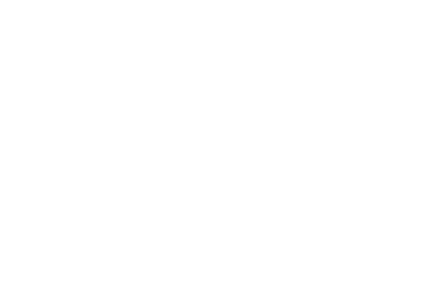

In [38]:
functionality3(('2008-11-13', '2008-11-14'), [24,25,26,27,1342177304,29,30,1409286171])

### Results
Since the interactions between more than two users in the form a---comment--> B ---answer---> C ---comment---> D---answer---> E and so on are very few, we can easily see that the output in the stackoverflow graph is empty and it'll be as it is for many date range.<br>

The visualization can be seen on a sample graph in the below cells in order to understand how it'll appear with more connected graphs

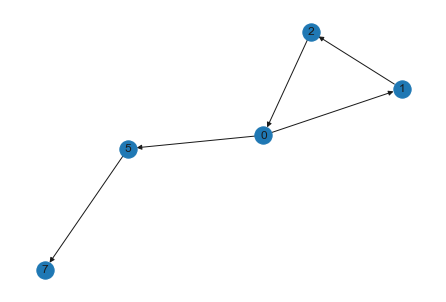

In [40]:
view_f3(G, [0,1,2,5,7])

### Functionality 4 - Disconnecting graphs
It takes in input:

Two different intervals of time (disjoint or not), which will lead to two different graphs, G_1 (associated to interval 1) and G_2 (associated to interval 2)
Two users which are unique to each interval of time (user_1 only appears in interval 1, while user_2 only appears in interval 2)
The function should return the minimum number of links (considering their weights) required to disconnect the two graphs.

In [58]:
def BFS(G, s, t, parent): 
    nodes = nx.nodes(G)
    visited = {key: False for key in nodes}
    queue=[] 
    visited[s] = True
    queue.append(s)
    while queue: 
        node = queue.pop(0) 
        if(node not in nodes):
            continue
 
        for idx in G[node]:
            if (not visited[idx] and G[node][idx]['weight'] > 0) : 
                queue.append(idx) 
                visited[idx] = True
                parent[idx] = node

    return visited[t]

def dfs(G,s,visited):
    visited[s]=True
    for node in G[s]:
        if G[s][node]["weight"] > 0 and not visited[node]:
            dfs(G,node,visited)
            
def minCut(G, source, sink): 
    graph = G.copy()
    nodes = nx.nodes(G)
    parent = {key: -1 for key in nx.nodes(G)}
    max_flow = 0 
    s = sink
    while(BFS(graph, source, sink, parent)) : 
        path_flow = float("inf") 
        
        while(s != source): 
            path_flow = min(path_flow, G[parent[s]][s]['weight']) 
            s = parent[s] 
        max_flow += path_flow 
        v = sink 
        while(v != source): 
            u = parent[v] 
            graph[u][v]["weight"] -= path_flow 
            if(v in nodes and u in graph[v]):
                graph[v][u]["weight"] += path_flow 
            v = parent[v] 
    visited ={key: False for key in nodes}
    dfs(graph,s,visited)
    edge_to_remove = []
    weight = 0
    for i in nodes:
        for j in G[i]:
            if (graph[i][j]["weight"] == 0) and (visited[i]):
                edge_to_remove.append((i, j))
                weight += G[i][j]["weight"]
                
    return edge_to_remove, weight

In [59]:
import numpy as np 
def functionality4(date_range1, date_range2, user1, user2):

    g1 = get_unique_graph(date_range1)
    print(f"Retrieved graph 1 from date range: {date_range1}")

    g2 = get_unique_graph(date_range2)
    print(f"Retrieved graph 2 from date range: {date_range2}")
    
    unique_users1 = g1.nodes.difference(g2.nodes)
    unique_users2 = g2.nodes.difference(g1.nodes)
    if user1 not in unique_users1 or user2 not in unique_users2:
        print(f"The pair of users ({user1},{user2}) are not unique for each graph.")
        user1 = np.random.choice(list(unique_users1))
        user2 = np.random.choice(list(unique_users2))
        print(f"Will be used the pair: ({user1},{user2})")
    

    g = get_unique_graph([date_range1, date_range2])
    print("Retrieved total graph")
    g=create_my_graph(g.adiacency_lists)
    return minCut(g, user1, user2), g


### Results
Since, as for the third functionality, the majority of the nodes are connected only to one neighbour, as it's show by the following cell of code, we'll show the work of our funcionality on another sample graph.  

In [36]:

nodes = np.random.choice(list(g1.adiacency_lists.keys()), size=100)
for n in nodes:
    l = nx.dag_longest_path_length(g, n)
    if l>1:
        print(f"node: {n}, len: {l}")


In [15]:
f4 = functionality4(('2008-11-13', '2008-11-14'), ('2008-11-16', '2008-11-17'), 25, 59)
f4

reading the files:
	-answer to questions: data/original/a2q_casted.csv	-comment to answers: data/original/c2a_casted.csv	-comment to questions: data/original/c2q_casted.csv
done in 12.919s
filtering the dataframes...
done in 0.798s
generating the weights
- multiplying by the coefficients: [3, 2, 1]
done in 0.095s
putting all togheter, it may require some time...
done in 0.152s
retrieving the graph
done in 2.642s tot time elapsed: 16.609
Retrieved graph 1 from date range: ('2008-11-13', '2008-11-14')
reading the files:
	-answer to questions: data/original/a2q_casted.csv	-comment to answers: data/original/c2a_casted.csv	-comment to questions: data/original/c2q_casted.csv
done in 12.79s
filtering the dataframes...
done in 0.736s
generating the weights
- multiplying by the coefficients: [3, 2, 1]
done in 0.084s
putting all togheter, it may require some time...
done in 0.125s
retrieving the graph
done in 2.237s tot time elapsed: 15.974
Retrieved graph 2 from date range: ('2008-11-16', '2008

([], 0)

## Visualization
functionality 4

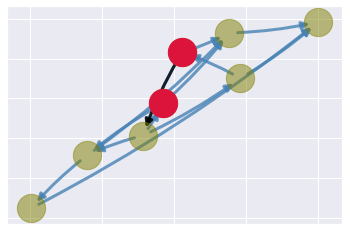

In [60]:
import matplotlib.pyplot as plt


sample_g = {0:[(1,1), (5,2)],1:[(2,1),(3,1), (4,3)], 2:[(0,3), (7, 5)], 3:[(4, 1),(5, 1)], 4:[(5,0),(6, 1)], 5: [(7,2)], 6:[(7,0)]}
user1 = 0
user2 = 3

def view_f4(user1, user2, dr1=None,dr2=None, sample_g=None):
    
    if sample_g is not None:
        subG = create_my_graph(sample_g)
    else:
        cutted_edges, subG = functionality4(dr1, dr2, user1, user2)

    pos = nx.spring_layout(subG, k=0.40, iterations=20, seed = 12)  
    edges = [(u, v) for (u, v, d) in subG.edges(data=True) if u != v]

    # add nodes to the graph
    nx.draw_networkx_nodes(subG, pos, node_size=800, node_color='olive', 
                        alpha = .5, label = 'Neighbors of input node')

    # draw the node of interest (input)
    nx.draw_networkx_nodes(subG, pos, node_size=800, nodelist = [user1, user2], 
                        node_color='crimson')

    nx.draw_networkx_edges(subG, pos, edgelist=edges, width=3, alpha = 0.8, edge_color="steelblue", 
                        arrowsize=15, connectionstyle='arc3,rad=0.05')

    if sample_g is not None:
        cutted_edges, _ = minCut(subG, user1, user2)

    nx.draw_networkx_edges(subG, pos, edgelist=cutted_edges, width=3, alpha = 0.8, edge_color="black", 
                        arrowsize=15, connectionstyle='arc3,rad=0.05')

    ax = plt.gca()
    ax.margins(0.03)
    plt.show()

view_f4(user1, user2, sample_g=sample_g)

## 4. Algorithmic question 

A number ***n*** of kids are in a camp. Between some ***k*** pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is linear in ***n*** and ***k*** that is able to answer whether such an assignment is possible and, if so, return one.

### Solution

This problem consists simply in a bicoloration of a graph. We can in fact think at this problem as if we have a graph that has for nodes all the kids and has one edge only between the pairs of fighting kids, we'll put each kid in a room that doesn't contains an 'enemy' *if and only if* we can colour the graph with two colour in such a way that each parent has a different colour from their children.

The algorithm that I'm going to show is a modified BFS, so it's computational complexity is $O(n+k)$ and it's sure that terminates, it's also correct because we'll bicolour each graph that doesn't have an odd cycle.

Let's see:
suppose to have a boolean colouring
```
bicolor(G):
    n1 = G.nodes[0]
    colors=[None for _ in range(len(G.nodes))]
    colors[n1] = True
    frounteer = queue(n1)
    while frounteer:
        n = frounteer.pop()
        for son in G[n]:
            if colors[son] is None:
                colors[son] = not colors[n]
                frounteer.enqueue(son)
            elif colors[son]==colors[n]:
                return False # the son is already coloured with the same colour (they cannot be in the same room but this is their destiny)
    None is in colors:  # disconnected parts
        G.remove_nodes([nodes that has a colour != None])
        return bicolor(G)
    
    return True
```


In [50]:
def bicolor(G):
    nodes = list(G.keys())
    n1 = nodes[0]
    colors={n: None for n in nodes}
    colors[n1] = True
    frounteer = [n1]
    while len(frounteer)>0:
        n = frounteer.pop(0)
        for son in G[n]:
            if colors[son] is None:
                colors[son] = not colors[n]
                frounteer.append(son)
            elif colors[son]==colors[n]:
                return False, colors
    if None in colors.values():  # disconnected parts
        G = {n:G[n] for n in G if colors[n] is None}
        possible, colors_bis = bicolor(G)
        colors.update(colors_bis)
        return possible, colors
    
    return True, colors

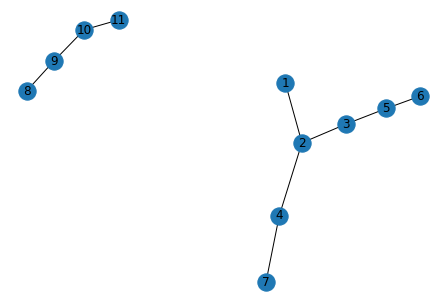

In [51]:
import networkx as nx

G = {1:[2], 2:[1, 3, 4], 3:[2,5], 5:[3, 6], 6:[5], 7:[4], 4:[2,7], 8:[9], 9:[8, 10], 10:[9, 11], 11:[10]}
nx_G = nx.from_dict_of_lists(G)
# nx.draw(G, node_color=color_map, with_labels=True)
nx.draw(nx_G, with_labels=True)

In [52]:

lab, cols = bicolor(G)
print(cols)

{1: True, 2: False, 3: True, 5: False, 6: True, 7: False, 4: True, 8: True, 9: False, 10: True, 11: False}


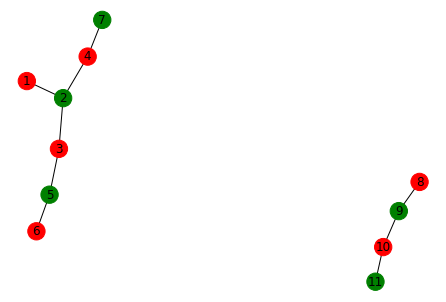

In [53]:
nx.draw(nx_G, with_labels=True, node_color= ['red' if cols[n] else 'green' if cols[n] is not None else 'black' for n in nx_G])

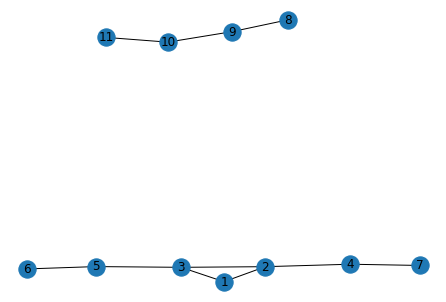

In [56]:
G_no = {1:[2, 3], 2:[1, 3, 4], 3:[2 ,5, 1], 5:[3, 6], 6:[5], 7:[4], 4:[2,7], 8:[9], 9:[8, 10], 10:[9, 11], 11:[10]}
nx_G_no = nx.from_dict_of_lists(G_no)
# nx.draw(G, node_color=color_map, with_labels=True)
nx.draw(nx_G_no, with_labels=True)

In [57]:
lab_no, cols_no = bicolor(G_no)
print(lab_no, cols_no)

False {1: True, 2: False, 3: False, 5: None, 6: None, 7: None, 4: None, 8: None, 9: None, 10: None, 11: None}


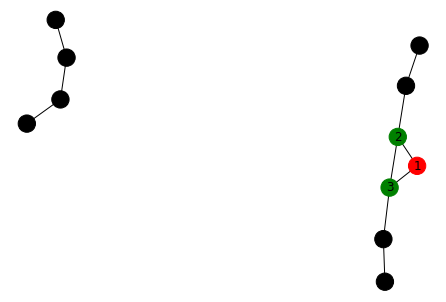

In [58]:
nx.draw(nx_G_no, with_labels=True, node_color= ['red' if cols_no[n] else 'green' if cols_no[n] is not None else 'black' for n in nx_G_no])

### Correctness
The problems raise only when in the graph there are odd cycles, but let's see why:
1. If we have no cycles then we can alternate the colour without meet the same node two times, so without problem of compatibility
2. If we have an even cycle we have that we can alternate the colours so for size 4 we have (c1,c2,c1,c2) and it's okay and adding 2 nodes means to have (c1,c2,c1,c2,c1,c2) and we can proceed without any problem
3. If we have an odd cycle we have an even cycle that can be well coloured (c1,c2,c1,c2) and at this we add a node this node is c1 or c2 and in both cases we'll not respect the condition of the bicolouring respectively with the first and with the fourth node